# Task 1


In [ ]:
import os
import cv2
import numpy as np

CUR_DIR = os.getcwd()

# Reading the image file, in the BGR color space.
image = cv2.imread(os.path.join(CUR_DIR, "for_watson.png"), cv2.IMREAD_COLOR)

# Transforming BGR image to Grayscale - MESSAGE : My Dear Watson,
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow("image_gray", image_gray)
cv2.imwrite("for_watson_gray.png", image_gray)

# Sharpening the grayscale image using a kernel of size 3x3.
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
image_gray_sharp = cv2.filter2D(image_gray, -1, kernel)
cv2.imshow("image_gray_sharp", image_gray_sharp)
cv2.imwrite("for_watson_gray_sharp.png", image_gray_sharp)

# Press 0 to destroy all windows.
cv2.waitKey(0)
cv2.destroyAllWindows()


# Task 2


# Task 3


## Calibrate camera using photos of AprilTag markers


In [ ]:
"""
Calibrate camera using AprilTag markers
"""

import importlib
import os
import sys

import pyAprilTag

CUR_DIR = os.getcwd()
LOG_DIR = os.path.join(CUR_DIR, "calib_log")
sys.path.insert(0, CUR_DIR)  # otherwise importlib cannot find the path

# If calib_log doesn't exist, create it.
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)
    pyAprilTag.calib(
        pyAprilTag.calib_pattern_path,
        "photo://{}".format(os.path.join(pyAprilTag.calib_example_dir, "*.png")),
        log_dir=LOG_DIR,
        nDistCoeffs=4,
    )

logs = sorted([f for f in os.listdir(LOG_DIR) if f.endswith(".py")])
if len(logs) == 0:
    print("no calibration log available!")
    exit(-1)

last_log = os.path.relpath(os.path.join(LOG_DIR, logs[-1])).replace(os.path.sep, ".")[
    :-3
]

calib = importlib.import_module(last_log)
print("last log: " + last_log)
print("camera intrinsic matrix:")
print(calib.K)
print("camera distortion parameters:")
print(calib.distCoeffs)


## Calibrate camera using video feed of April Tags


In [7]:
"""
Calibrate camera using AprilTag markers
"""

import importlib
import os
import sys

import pyAprilTag

CUR_DIR = os.getcwd()
LOG_DIR = os.path.join(CUR_DIR, "calib_log")
sys.path.insert(0, CUR_DIR)  # otherwise importlib cannot find the path
if (
    not os.path.exists(LOG_DIR)
    or len([f.endswith(".png") for f in os.listdir(LOG_DIR)]) < 2
):
    os.makedirs(LOG_DIR)
    pyAprilTag.calib(
        pyAprilTag.calib_pattern_path,
        "camera://{:d}".format(0),
        log_dir=LOG_DIR,
        nDistCoeffs=4,
    )

logs = sorted([f for f in os.listdir(LOG_DIR) if f.endswith(".py")])
if len(logs) == 0:
    print("no calibration log available!")
    exit(-1)

last_log = os.path.relpath(os.path.join(LOG_DIR, logs[-1])).replace(os.path.sep, ".")[
    :-3
]
calib = importlib.import_module(last_log)

print(f"last log: {last_log}")
print(f"camera intrinsic matrix: {calib.K}")
print(f"camera distortion parameters: {calib.distCoeffs}")


last log: calib_log.AprilCalib_log_00063
camera intrinsic matrix: [[644.15348109   0.         317.47593567]
 [  0.         644.52101185 242.9762921 ]
 [  0.           0.           1.        ]]
camera distortion parameters: [-0.0271262  -0.01459669  0.00078423 -0.00342669  0.        ]


# Task 4


In [1]:
import importlib
import os
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pyAprilTag

## Read the calibration log from task 3 and get camera parameters

- K - Camera calibration atrix
- distCoeffs - Distortion coefficients 

In [2]:
def get_calib_from_log():

    # define current and calibration lof directories
    CUR_DIR = os.getcwd()
    LOG_DIR = os.path.join(CUR_DIR, "calib_log")
    sys.path.insert(0, CUR_DIR)  # otherwise importlib cannot find the path

    # read the logs from .py files in calib log folder.
    logs = sorted([f for f in os.listdir(LOG_DIR) if f.endswith(".py")])

    # check if the logs are empty
    if len(logs) == 0:
        print("no calibration log available!")
        exit(-1)

    # get the most recent calibration log  
    last_log = os.path.relpath(os.path.join(LOG_DIR, logs[-1])).replace(
        os.path.sep, "."
    )[:-3]
    
    return importlib.import_module(last_log)


# get calibration matrix and distortion coefficients
K = get_calib_from_log().K
distCoeffs = get_calib_from_log().distCoeffs


In [3]:
def draw_cube(image, image_points):
    """
    Function to draw a cube given 8 points of a cube on the image.
    input:
        image - input image
        image_points - list of projected 8 points of a cube.
    output:
        
    """
    image = cv2.line(image, image_points[0], image_points[1], color=(0 ,0, 255), thickness=4)    
    image = cv2.line(image, image_points[0], image_points[3], color=(0 ,0, 255), thickness=4)    
    image = cv2.line(image, image_points[0], image_points[4], color=(0 ,0, 255), thickness=4)    
    image = cv2.line(image, image_points[1], image_points[2], color=(0 ,0, 255), thickness=4)    
    image = cv2.line(image, image_points[1], image_points[5], color=(0 ,0, 255), thickness=4)    
    image = cv2.line(image, image_points[2], image_points[3], color=(0 ,0, 255), thickness=4)    
    image = cv2.line(image, image_points[2], image_points[6], color=(0 ,0, 255), thickness=4)    
    image = cv2.line(image, image_points[3], image_points[7], color=(0 ,0, 255), thickness=4)    
    image = cv2.line(image, image_points[4], image_points[5], color=(0 ,0, 255), thickness=4)    
    image = cv2.line(image, image_points[4], image_points[7], color=(0 ,0, 255), thickness=4)    
    image = cv2.line(image, image_points[5], image_points[6], color=(0 ,0, 255), thickness=4)    
    image = cv2.line(image, image_points[6], image_points[7], color=(0 ,0, 255), thickness=4)
    
    return image

##  Next we will read two images and find an april tag in them. Each of them contains one april tag.

- `image1.jpg` is read as `img1`
- `image2.jpg` is read as `img2`
- `pyAprilTag.find()` finds the coordinates of the corners and centers, along with the ID and homography  of the april tags.
- Corners are of the shape (1,4,2) so we reshape them to (4, 2)
- We can discard the homographies, ids and centers as we don't need them.

In [17]:
img1 = cv2.imread("image1.jpg")
img2 = cv2.imread("image2.jpg")

# find corners of april tag
ids1, corners1, centers1, homographies1 = pyAprilTag.find(img1)
ids2, corners2, centers2, homographies2 = pyAprilTag.find(img2)

# reeshape to (4,2)
corners1 = corners1.reshape(-1, 2)
corners2 = corners2.reshape(-1, 2)

## Now we will define a cube using 8 points in  the 3D space.

The points of the cube that we would be projecting are - $$(1, 1, 1), \\(2, 1, 1), \\ (2, 2, 1), \\ (1, 2, 1), \\ (1, 1, 2), \\ (2, 1, 2), \\ (2, 2, 2), \\ (1, 2, 2)$$

After this, we will select a cube face to solve a PnP transformation between this face and the plane of the april tag. The points of the cube face we've selected  are
$$(1, 1, 1), \\(2, 1, 1), \\ (2, 2, 1), \\ (1, 2, 1)$$



In [18]:
# define 3d cube points
cube_points = np.float32(
    [
        [1, 1, 1],
        [2, 1, 1],
        [2, 2, 1],
        [1, 2, 1],
        [1, 1, 2],
        [2, 1, 2],
        [2, 2, 2],
        [1, 2, 2],
    ]
)

# define cube face
cube_face = np.float32([[1, 1, 1], [2, 1, 1], [2, 2, 1], [1, 2, 1]])

# solve the perspective n point problem to find the pose of the camera.
flags = cv2.SOLVEPNP_ITERATIVE
ret1, rvec1, tvec1 = cv2.solvePnP(cube_face, corners1, K, distCoeffs, flags=flags)
ret2, rvec2, tvec2 = cv2.solvePnP(cube_face, corners2, K, distCoeffs, flags=flags)

## Project the cube on the image

In [19]:
cube_img1_points, jac = cv2.projectPoints(cube_points, rvec1, tvec1, K, distCoeffs)
cube_img2_points, jac = cv2.projectPoints(cube_points, rvec2, tvec2, K, distCoeffs)

## Reshape into (4, 2) vector and round the float values to integer

In [20]:
cube_img1_points = cube_img1_points.reshape(-1, 2).round()
cube_img2_points = cube_img2_points.reshape(-1, 2).round()

## Convert points to tuples so that we can pass it to `cv2.line``

In [21]:
cube_img1_points = list(map(tuple, cube_img1_points))
cube_img2_points = list(map(tuple, cube_img2_points))

In [22]:
cube_img2_points

[(714.0, 514.0),
 (881.0, 632.0),
 (1137.0, 383.0),
 (911.0, 361.0),
 (555.0, 314.0),
 (633.0, 320.0),
 (924.0, 91.0),
 (746.0, 167.0)]

## Draw the cube on each image

In [23]:
img1 = draw_cube(img1, cube_img1_points)
img2 = draw_cube(img2, cube_img2_points)

## Show and write each output image to disk

In [25]:
# show image
cv2.imshow("IMAGE 1", img1)
cv2.imshow("IMAGE 2", img2)

# write image
cv2.imwrite("image1_cube.jpg", img1)
cv2.imwrite("image2_cube.jpg", img2)

# Press any key to destroy windows
cv2.waitKey(0)
cv2.destroyAllWindows()

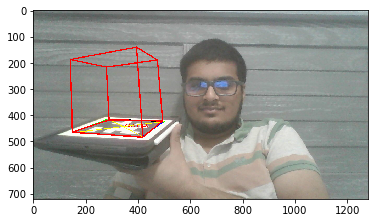

In [28]:
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

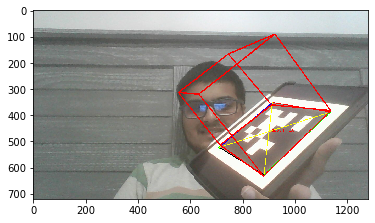

In [29]:
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))